In [1]:
%load_ext autoreload
%autoreload 2

import json
from arcworld.general_utils import plot_grid, plot_task

# Compositionality

In [ ]:
with open('before_arc_datasets/compositionality/exp_setting_3/experiment_1/val.json', 'r') as f:
    train = json.load(f)

with open('before_arc_datasets/generalization/exp_setting_5/experiment_5/val_ood.json', 'r') as f:
    val = json.load(f)
    
with open('before_arc_datasets/generalization/exp_setting_5/experiment_5/test.json', 'r') as f:
    test = json.load(f)
    
# print lengths
print(f"train: {len(train)}")
print(f"val: {len(val)}")
print(f"test: {len(test)}")

    
import pandas as pd

train = pd.read_parquet('before-arc-parquet/generalization/exp_setting_4/experiment_1/train.parquet', engine='pyarrow')
test = pd.read_parquet('before-arc-parquet/generalization/exp_setting_4/experiment_1/test.parquet', engine='pyarrow')
test_ood = pd.read_parquet('before-arc-parquet/generalization/exp_setting_4/experiment_1/test_ood.parquet', engine='pyarrow')
 

# with open('before-arc-parquet/compositionality/exp_setting_4/experiment_1/train.parquet', 'r') as f:
#     train_parquet = json.load(f)

FileNotFoundError: [Errno 2] No such file or directory: 'before_arc_datasets/generalization/exp_setting_5/experiment_5/val_ood.json'

In [36]:
# print(test[80]['transformation_suite'])
# convert df to dict 
train = train.to_dict(orient='records')
test = test.to_dict(orient='records')
test_ood = test_ood.to_dict(orient='records')

AttributeError: 'list' object has no attribute 'to_dict'

In [11]:
train_transform_history = {}
for i in range(len(train)):
    transform = str(train[i]['transformation_suite'])
    if transform not in train_transform_history.keys():
        train_transform_history[transform] = 1
    else:
        train_transform_history[transform] += 1

In [12]:
test_transform_history = {} 
for i in range(len(test)):
    transform = str(test[i]['transformation_suite'])
    if transform not in test_transform_history.keys():
        test_transform_history[transform] = 1
    else:
        test_transform_history[transform] += 1
        

val_transform_history = {} 
for i in range(len(val)):
    transform = str(val[i]['transformation_suite'])
    if transform not in val_transform_history.keys():
        val_transform_history[transform] = 1
    else:
        val_transform_history[transform] += 1

In [13]:
print("\n Train Transformations History \n")

for key in train_transform_history.keys():
    print(key, train_transform_history[key])

print("\n Test Transformations History \n")

for key in test_transform_history.keys():
    print(key, test_transform_history[key])
    
print("\n Test OOD Transformations History \n")

for key in val_transform_history.keys():
    print(key, val_transform_history[key])


 Train Transformations History 

['extend_contours_same_color'] 20

 Test Transformations History 

['extend_contours_same_color'] 20

 Test OOD Transformations History 

['extend_contours_same_color'] 20


['extend_contours_same_color']


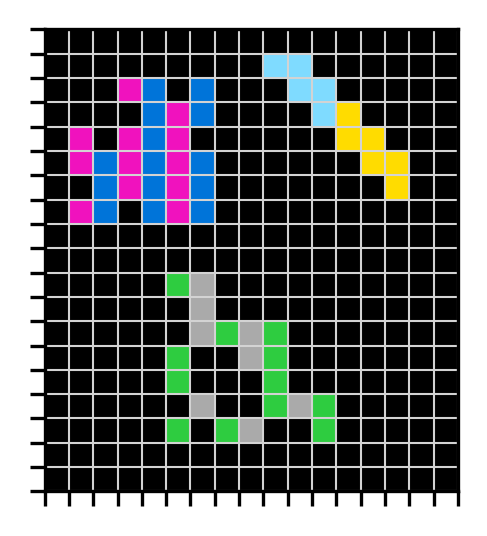

In [14]:
import numpy as np
plot_grid(np.array(list(val[15]['input'])), size = (2,2))
print(val[15]["transformation_suite"])

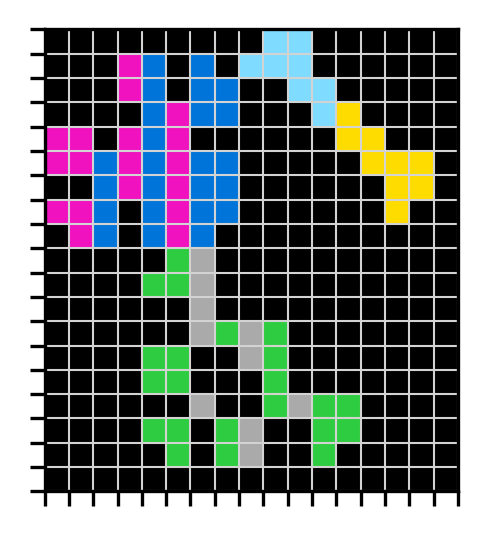

In [15]:
plot_grid(np.array(list(val[15]['output'])), size = (2,2))

# Generalization

In [50]:
with open('before_arc_datasets/generalization/exp_setting_1/experiment_2/train.json', 'r') as f:
    train_1_2 = json.load(f)

with open('before_arc_datasets/generalization/exp_setting_1/experiment_2/train_val.json', 'r') as f:
    train_val_1_2 = json.load(f)
    
with open('before_arc_datasets/generalization/exp_setting_3/experiment_4/test.json', 'r') as f:
    test_3_4 = json.load(f)

with open('before_arc_datasets/generalization/exp_setting_5/experiment_2/test_val.json', 'r') as f:
    test_val_5_2 = json.load(f)

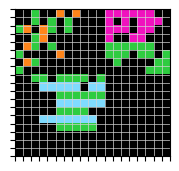

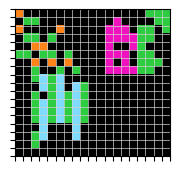

In [53]:
to_check = [train_1_2, train_val_1_2, test_3_4, test_val_5_2]
plot_grid(test_val_5_2[2]['input'], size = (2,2))
plot_grid(test_val_5_2[2]['output'], size = (2,2))

In [2]:
import time
import sys 
from arcworld.general_utils import plot_task, plot_grid
from study_configs.generalization import generalization_configs
from generator import generator
import numpy as np
from arcworld.general_utils import find_possible_positions, randomly_add_shape_to_world

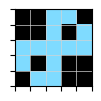

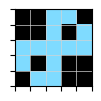

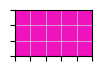

In [12]:
config = generalization_configs[-1]
gen = generator(config)
shapes = gen.randomly_sample_shapes([20000, 31, 52, 67], 3)
plot_grid(shapes[0].as_shape_only_grid, size = (1,1))
plot_grid(shapes[1].as_shape_only_grid, size = (1,1)) 
plot_grid(shapes[2].as_shape_only_grid, size = (1,1))

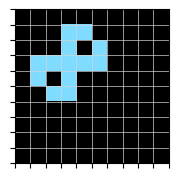

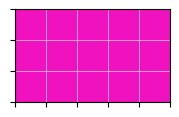

In [40]:
grid = np.zeros((10,10))
new_grid, shape_positionned = randomly_add_shape_to_world(grid, shapes[1])
plot_grid(new_grid, size = (2,2))
plot_grid(shapes[2].as_shape_only_grid, size = (2,2))


In [44]:
import numpy as np
from scipy.ndimage import binary_dilation

def find_safe_positions(original_grid, object_to_position):
    m, n = original_grid.shape
    h, w = object_to_position.shape

    # 4-connectivity structure: no diagonals
    structure = np.array([[0, 1, 0],
                          [1, 1, 1],
                          [0, 1, 0]])

    # Create a binary mask of the existing objects
    existing_objects = (original_grid != 0)

    # Dilate using 4-connectivity to define the forbidden zone
    forbidden_zone = binary_dilation(existing_objects, structure=structure)

    safe_positions = []

    for i in range(m - h + 1):
        for j in range(n - w + 1):
            # Extract the region where the object would be placed
            region = forbidden_zone[i:i+h, j:j+w]

            # Ensure there's no overlap between the object and the forbidden zone
            if not np.any(region & (object_to_position != 0)):
                safe_positions.append((i, j))

    return safe_positions

import numpy as np

def find_safe_positions_new(original_grid, object_to_position):
    m, n = original_grid.shape
    h, w = object_to_position.shape

    safe_positions = []

    # Precompute object non-zero mask
    object_mask = (object_to_position != 0)

    # Define 8-connected neighborhood (including diagonals)
    neighbors = [(-1, -1), (-1, 0), (-1, 1),
                 ( 0, -1),          ( 0, 1),
                 ( 1, -1), ( 1, 0), ( 1, 1)]

    for i in range(m - h + 1):
        for j in range(n - w + 1):
            valid = True

            for di in range(h):
                for dj in range(w):
                    if not object_mask[di, dj]:
                        continue

                    # Absolute position on the grid
                    gi, gj = i + di, j + dj

                    # Check if this position or its 8 neighbors are touching non-zero pixels in the grid
                    for ni, nj in neighbors + [(0, 0)]:  # include the pixel itself
                        ni_g, nj_g = gi + ni, gj + nj
                        if 0 <= ni_g < m and 0 <= nj_g < n:
                            if original_grid[ni_g, nj_g] != 0:
                                valid = False
                                break
                    if not valid:
                        break
                if not valid:
                    break

            if valid:
                safe_positions.append((i, j))

    return safe_positions

import numpy as np

def find_safe_positions_new_grok(original_grid, object_to_position):
    m, n = original_grid.shape
    h, w = object_to_position.shape
    
    # Precompute valid search space
    safe_positions = []
    object_mask = (object_to_position != 0)
    
    # Create a binary dilation of non-zero grid cells for faster neighbor checking
    from scipy.ndimage import binary_dilation
    # Create a 3x3 structuring element for 8-connectivity
    structure = np.ones((3, 3), dtype=bool)
    # Dilate non-zero cells to mark their 8-connected neighborhood
    danger_zone = binary_dilation(original_grid != 0, structure=structure)
    
    # Vectorize the position checking
    valid_i = np.arange(m - h + 1)
    valid_j = np.arange(n - w + 1)
    jj, ii = np.meshgrid(valid_j, valid_i)
    
    # Flatten for iteration
    positions = np.column_stack((ii.ravel(), jj.ravel()))
    
    for i, j in positions:
        # Check if any part of the object would overlap with danger zone
        region = danger_zone[i:i+h, j:j+w]
        if not np.any(region & object_mask):
            safe_positions.append((i, j))
    
    return safe_positions


In [45]:
# Time all functions 

import time

start = time.time()
for i in range(100):
    ind = find_safe_positions_new_grok(new_grid, shapes[2].as_shape_only_grid)
end = time.time()
print("Grok function time: ", end - start)
start = time.time()
for i in range(100):
    ind = find_safe_positions_new(new_grid, shapes[2].as_shape_only_grid)
end = time.time()
print("New function time: ", end - start)

start = time.time()
zeroedworld = new_grid.copy()
zeroedworld[new_grid == 0] = 0
for i in range(100):
    ind = find_possible_positions(zeroedworld, shapes[2].as_shape_only_grid)
end = time.time()
print("Original function time: ", end - start)

Grok function time:  0.013727188110351562
New function time:  0.012234926223754883
Original function time:  0.005756855010986328


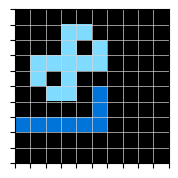

In [42]:
indexes = find_safe_positions_new(new_grid, shapes[2].as_shape_only_grid)


editing_new_grid = new_grid.copy()
for ind in indexes:
    editing_new_grid[ind[0], ind[1]] = 1
plot_grid(editing_new_grid, size = (2,2))

(3, 5)
(5, 7)
(5, 7)


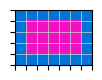

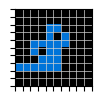

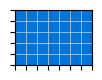

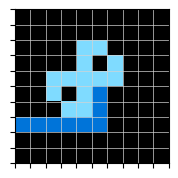

In [22]:
zeroedworld = new_grid.copy()
zeroedworld[new_grid == 0] = 0
indexes = find_possible_positions(zeroedworld, shapes[2].grid)
for ind in indexes:
    new_grid[ind[0], ind[1]] = 1
plot_grid(new_grid, size = (2,2))


{'min_n_shapes_per_grid': 3, 'max_n_shapes_per_grid': 4, 'n_examples': 1, 'min_grid_size': 16, 'max_grid_size': 20, 'allowed_combinations': [['crop_top_side']], 'allowed_transformations': None, 'min_transformation_depth': None, 'max_transformation_depth': None, 'shape_compulsory_conditionals': ['is_shape_not_symmetric', 'is_shape_not_evenly_colored', 'is_shape_less_than_11_rows', 'is_shape_less_than_11_cols', 'is_shape_more_than_5_rows', 'is_shape_more_than_5_cols'], 'saving_path': 'before_arc_datasets/generalization/exp_setting_5/experiment_4/test.json'}


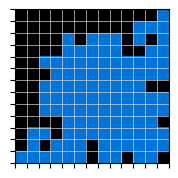

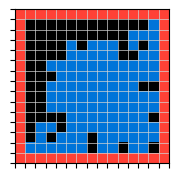

In [33]:
import numpy as np
config = generalization_configs[-1]
print(config)
gen = generator(config)
shapes = gen.randomly_sample_shapes([1001], 1)
plot_grid(shapes[0].as_shape_only_grid, size = (2,2))
grid = shapes[0].as_shape_only_grid
# pad grid 
padded_grid = np.pad(grid, ((1, 1), (1, 1)), mode='constant', constant_values=2)
plot_grid(padded_grid, size = (2,2))


(13, 13)
(13, 13)


/var/folders/vw/9_mx55bd2xv8_v7v_67539680000gn/T/ipykernel_28524/1846188384.py:4: DeprecationWarning: Please import `binary_dilation` from the `scipy.ndimage` namespace; the `scipy.ndimage.morphology` namespace is deprecated and will be removed in SciPy 2.0.0.
  dilated_shape = scipy.ndimage.morphology.binary_dilation(shapes[0].as_shape_only_grid,


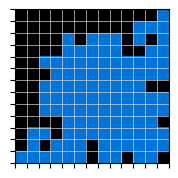

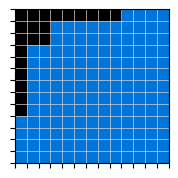

In [46]:
import scipy
plot_grid(shapes[0].as_shape_only_grid, size = (2,2))
print(shapes[0].as_shape_only_grid.shape)
dilated_shape = scipy.ndimage.morphology.binary_dilation(shapes[0].as_shape_only_grid, 
                                                         structure = scipy.ndimage.generate_binary_structure(2, 2)).astype(int)
plot_grid(dilated_shape, size = (2,2))
print(dilated_shape.shape)
        

In [27]:
from datasets import load_dataset

dict_of_transformations = {}

def update_dict(file, dict_of_transformations):
    for i in range(len(file)):
        transformations = file[i]['transformation_suite']
        for transform in transformations:
            if transform not in dict_of_transformations.keys():
                dict_of_transformations[transform] = 1
            else:
                dict_of_transformations[transform] += 1
    return dict_of_transformations


for exps in range(1, 4):
    for exp in range(1, 6):

        # Open data from HF 
        val_path = f"compositionality/exp_setting_{exps}/experiment_{exp}/val.parquet"
        test_path = f"compositionality/exp_setting_{exps}/experiment_{exp}/test_ood.parquet"
        val = load_dataset("taratataw/before-arc", data_files={"data": val_path})
        test = load_dataset("taratataw/before-arc", data_files={"data": test_path})
        
        dict_of_transformations = update_dict(val['data'], dict_of_transformations)
        dict_of_transformations = update_dict(test['data'], dict_of_transformations)

        print(dict_of_transformations)
        


{'translate_up': 1445, 'rot90': 1555, 'mirror_horizontal': 666}
{'translate_up': 1445, 'rot90': 1555, 'mirror_horizontal': 666, 'pad_right': 1500, 'fill_holes_different_color': 600, 'change_shape_color': 1600}
{'translate_up': 1445, 'rot90': 3111, 'mirror_horizontal': 666, 'pad_right': 1500, 'fill_holes_different_color': 600, 'change_shape_color': 1600, 'pad_top': 555, 'crop_bottom_side': 1555}
{'translate_up': 1445, 'rot90': 3111, 'mirror_horizontal': 2221, 'pad_right': 1500, 'fill_holes_different_color': 600, 'change_shape_color': 1600, 'pad_top': 555, 'crop_bottom_side': 1555, 'extend_contours_different_color': 1556, 'translate_down': 555}
{'translate_up': 1445, 'rot90': 3111, 'mirror_horizontal': 2221, 'pad_right': 1500, 'fill_holes_different_color': 600, 'change_shape_color': 1600, 'pad_top': 555, 'crop_bottom_side': 1555, 'extend_contours_different_color': 1556, 'translate_down': 555, 'extend_contours_same_color': 1556, 'pad_left': 1555, 'mirror_vertical': 555}
{'translate_up': 2

Generating data split: 1000 examples [00:00, 364848.99 examples/s]
Generating data split: 1000 examples [00:00, 257477.23 examples/s]


{'translate_up': 2951, 'rot90': 4775, 'mirror_horizontal': 3051, 'pad_right': 3080, 'fill_holes_different_color': 1310, 'change_shape_color': 3310, 'pad_top': 555, 'crop_bottom_side': 1555, 'extend_contours_different_color': 1556, 'translate_down': 555, 'extend_contours_same_color': 1556, 'pad_left': 1555, 'mirror_vertical': 555}


Generating data split: 1000 examples [00:00, 428646.30 examples/s]
Generating data split: 1000 examples [00:00, 280686.88 examples/s]


{'translate_up': 2951, 'rot90': 6447, 'mirror_horizontal': 3051, 'pad_right': 3080, 'fill_holes_different_color': 1310, 'change_shape_color': 3310, 'pad_top': 1219, 'crop_bottom_side': 3219, 'extend_contours_different_color': 1556, 'translate_down': 555, 'extend_contours_same_color': 1556, 'pad_left': 1555, 'mirror_vertical': 555}


Generating data split: 1000 examples [00:00, 366859.44 examples/s]
Generating data split: 1001 examples [00:00, 244340.24 examples/s]


{'translate_up': 2951, 'rot90': 6447, 'mirror_horizontal': 3715, 'pad_right': 3080, 'fill_holes_different_color': 1310, 'change_shape_color': 3310, 'pad_top': 1219, 'crop_bottom_side': 3219, 'extend_contours_different_color': 2228, 'translate_down': 1219, 'extend_contours_same_color': 1556, 'pad_left': 1555, 'mirror_vertical': 555, 'crop_top_side': 1001}


Generating data split: 1000 examples [00:00, 365931.25 examples/s]
Generating data split: 1000 examples [00:00, 378786.60 examples/s]


{'translate_up': 2951, 'rot90': 6447, 'mirror_horizontal': 3715, 'pad_right': 3080, 'fill_holes_different_color': 1310, 'change_shape_color': 3310, 'pad_top': 1219, 'crop_bottom_side': 3219, 'extend_contours_different_color': 2228, 'translate_down': 1219, 'extend_contours_same_color': 3228, 'pad_left': 3219, 'mirror_vertical': 1219, 'crop_top_side': 1001}
{'translate_up': 4647, 'rot90': 7932, 'mirror_horizontal': 5200, 'pad_right': 3080, 'fill_holes_different_color': 1310, 'change_shape_color': 3310, 'pad_top': 1219, 'crop_bottom_side': 3219, 'extend_contours_different_color': 2228, 'translate_down': 1219, 'extend_contours_same_color': 3228, 'pad_left': 3219, 'mirror_vertical': 1219, 'crop_top_side': 1001}


Generating data split: 1000 examples [00:00, 277676.53 examples/s]
Generating data split: 1000 examples [00:00, 256156.35 examples/s]


{'translate_up': 4647, 'rot90': 7932, 'mirror_horizontal': 5200, 'pad_right': 4776, 'fill_holes_different_color': 2795, 'change_shape_color': 4795, 'pad_top': 1219, 'crop_bottom_side': 3219, 'extend_contours_different_color': 2228, 'translate_down': 1219, 'extend_contours_same_color': 3228, 'pad_left': 3219, 'mirror_vertical': 1219, 'crop_top_side': 1001}


Generating data split: 1000 examples [00:00, 268178.01 examples/s]
Generating data split: 1000 examples [00:00, 235794.02 examples/s]


{'translate_up': 4647, 'rot90': 9628, 'mirror_horizontal': 5200, 'pad_right': 4776, 'fill_holes_different_color': 2795, 'change_shape_color': 4795, 'pad_top': 2704, 'crop_bottom_side': 4704, 'extend_contours_different_color': 2228, 'translate_down': 1219, 'extend_contours_same_color': 3228, 'pad_left': 3219, 'mirror_vertical': 1219, 'crop_top_side': 1001}


Generating data split: 1000 examples [00:00, 286105.32 examples/s]
Generating data split: 1000 examples [00:00, 292653.08 examples/s]


{'translate_up': 4647, 'rot90': 9628, 'mirror_horizontal': 6685, 'pad_right': 4776, 'fill_holes_different_color': 2795, 'change_shape_color': 4795, 'pad_top': 2704, 'crop_bottom_side': 4704, 'extend_contours_different_color': 3924, 'translate_down': 2704, 'extend_contours_same_color': 3228, 'pad_left': 3219, 'mirror_vertical': 1219, 'crop_top_side': 1001}


Generating data split: 1000 examples [00:00, 294048.23 examples/s]
Generating data split: 1000 examples [00:00, 283456.38 examples/s]


{'translate_up': 4647, 'rot90': 9628, 'mirror_horizontal': 6685, 'pad_right': 4776, 'fill_holes_different_color': 2795, 'change_shape_color': 4795, 'pad_top': 2704, 'crop_bottom_side': 4704, 'extend_contours_different_color': 3924, 'translate_down': 2704, 'extend_contours_same_color': 4924, 'pad_left': 4704, 'mirror_vertical': 2704, 'crop_top_side': 1001}


In [20]:
val["data"][0]['transformation_suite']

['translate_up']

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.9/30.9 MB 1.4 MB/s eta 0:00:0000:0100:01
